In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torch.utils.data.dataset import Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
class TransformDataset(Dataset):
    
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the full training dataset into new training and validation datasets (80/20 split)
train_size = int(0.8 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(full_train_set)), [train_size, val_size])

train_dataset = TransformDataset(Subset(full_train_set, train_indices), transform=transform_train)
val_dataset = TransformDataset(Subset(full_train_set, val_indices), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()

        # First convolutional block
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)  

    def forward(self, x):
        # Each convolutional block followed by pooling
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = self.pool1(F.relu(self.bn1_2(self.conv1_2(x))))

        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = self.pool2(F.relu(self.bn2_2(self.conv2_2(x))))

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = self.pool3(F.relu(self.bn3_2(self.conv3_2(x))))

        # Flatten and pass through dense layers with dropout in between
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
model = MiniVGG()


In [5]:
# Loss function and optimizer with weight decay
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0008, weight_decay=0.005)  
scheduler = StepLR(optimizer, step_size= 20 , gamma=0.3)


# Device configuration
device = torch.device("cuda")
model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=120):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_samples = 0
        running_loss = 0.0
        running_correct = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_correct / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc * 100)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc * 100)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc * 100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc * 100:.2f}%')
        
        # Update the learning rate
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Start training with scheduler
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)



Epoch [1/120]: Train Loss: 1.9555, Train Acc: 30.74%, Val Loss: 1.6522, Val Acc: 42.33%
Epoch [2/120]: Train Loss: 1.5693, Train Acc: 43.97%, Val Loss: 1.4203, Val Acc: 49.61%
Epoch [3/120]: Train Loss: 1.3932, Train Acc: 50.38%, Val Loss: 1.3026, Val Acc: 53.47%
Epoch [4/120]: Train Loss: 1.2863, Train Acc: 54.05%, Val Loss: 1.2126, Val Acc: 56.85%
Epoch [5/120]: Train Loss: 1.2022, Train Acc: 57.44%, Val Loss: 1.1345, Val Acc: 59.83%
Epoch [6/120]: Train Loss: 1.1268, Train Acc: 60.09%, Val Loss: 1.0686, Val Acc: 62.15%
Epoch [7/120]: Train Loss: 1.0604, Train Acc: 62.45%, Val Loss: 1.0256, Val Acc: 63.53%
Epoch [8/120]: Train Loss: 1.0030, Train Acc: 64.72%, Val Loss: 0.9750, Val Acc: 65.41%
Epoch [9/120]: Train Loss: 0.9547, Train Acc: 66.47%, Val Loss: 0.9384, Val Acc: 66.15%
Epoch [10/120]: Train Loss: 0.9159, Train Acc: 67.85%, Val Loss: 0.8914, Val Acc: 68.55%
Epoch [11/120]: Train Loss: 0.8741, Train Acc: 69.36%, Val Loss: 0.8723, Val Acc: 69.09%
Epoch [12/120]: Train Loss: 0.

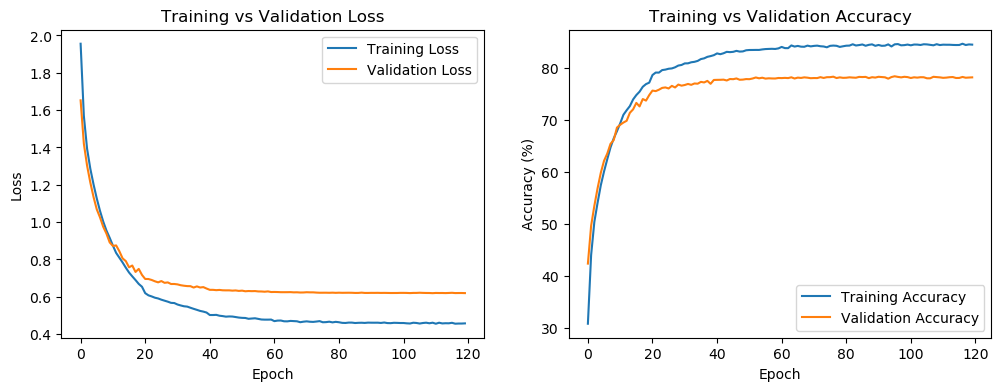

In [6]:

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [7]:
model.eval()  # Set the model to evaluation mode
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_set)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7853


### Observation:
 1) Each conv layer is followed by batch normalization which helped me in reducing overfitting and enhancing the learning of features. A dropout of 0.3 before the FC layer helped to prevent overfitting further. 
 2) Achieved Accuracy : 78.53